# Data init

In [ ]:
!pip install -U keras
!pip install -U tensorflow

In [40]:
import nltk
import re
import math
import sklearn
from nltk.corpus import stopwords

In [41]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# This cell code provided by kaggle

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ptbr-sentiment-analysis-datasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1426268%2F2361506%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T183009Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D271b47463f7826ef02fcacc0163c0798bee9eea7697f69b54dd19a49a2057843f0c3fb8da9d898ffff5c2a30e024ee7b163c457a6af4c89b83fc8e051eff6768f5bd47cda02011c0978c3c6f52b97005cb12b11fba6288b3bd8dcbc019d039cd83153676573f80abdae8db4c854ae178976389ab6977dad7b9b4411604b8a4451c041b4b75757422e31db0d93745269064bfe5ff2751d13e4d84e24b25c6f3d863bdc5e0c9751268381b3ba33b82e74d55b7e161ad65fd1e14e48e93171395bc429e8d8aa267be602ad25aa26cd3aaf0306a5d109c39241a365ec1cc5181c238be3627420ff06aa434ebe7bbc7c7bbc9df66dc100a48bda90073a587cc030a12'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 919706417 bytes downloaded
Downloaded and uncompressed: ptbr-sentiment-analysis-datasets
Data source import complete.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
dataset = pd.read_csv('/kaggle/input/ptbr-sentiment-analysis-datasets/utlc_apps.csv')
dataset.head()

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,2483729,eu curtindo muito,eu curtindo muito,"['eu', 'curtindo', 'muito']",1.0,5.0,1,1
1,2865805,Aplicativo absurdamente caro e o valor para se...,aplicativo absurdamente caro e o valor para se...,"['aplicativo', 'absurdamente', 'caro', 'valor'...",0.0,1.0,1,1
2,2734161,Não é mais tão simples com o novo layout,nao e mais tao simples com o novo layout,"['nao', 'mais', 'tao', 'simples', 'com', 'novo...",1.0,4.0,1,1
3,2066362,"Estava com um problema para acessar, porém con...","estava com um problema para acessar, porem con...","['estava', 'com', 'um', 'problema', 'para', 'a...",1.0,5.0,1,1
4,2521806,Eu gostei muito do jogo tenho no celular da mi...,eu gostei muito do jogo tenho no celular da mi...,"['eu', 'gostei', 'muito', 'do', 'jogo', 'tenho...",1.0,5.0,1,1


In [44]:
dataset.dropna(inplace = True)

In [45]:
dataset.drop(
    columns = [
        "original_index",
        "review_text_processed",
        "review_text_tokenized",
        "kfold_polarity",
        "kfold_rating",
    ],
    inplace = True
)

In [46]:
dataset

,review_text,polarity,rating
0,eu curtindo muito,1.0,5.0
1,Aplicativo absurdamente caro e o valor para se...,0.0,1.0
2,Não é mais tão simples com o novo layout,1.0,4.0
3,"Estava com um problema para acessar, porém con...",1.0,5.0
4,Eu gostei muito do jogo tenho no celular da mi...,1.0,5.0
...,...,...,...
1039530,legal!,1.0,4.0
1039531,"Mt bom o app ,assim dá pra ficar por dentro da...",1.0,5.0
1039532,Ele é Ok,0.0,1.0
1039533,Excelente aplicativo para treinar os conhecime...,1.0,5.0


In [47]:
print(f"Training has {dataset.shape} phrases")

Training has (968858, 3) phrases


# Cleaning data

In [48]:
def preprocessing(texts):
  t = re.sub(r'#','',texts)
  t = re.sub(r'hahaha','',texts)
  t = re.sub(r'\n','',texts)
  t = t.lower()
  t = re.sub(r'https:\/\/.*|http:\/\/.*','',texts)
  t = re.sub(r'[\,\+\=\-\_\?\[\]\{\}\@\.\'\$\!\&\>\<\;\"\(\)\:\/\\]+','',t)
  t = re.sub(r'[0-9]+','',t)
  return t

In [49]:
dataset['review_text'] = dataset['review_text'].apply(lambda x: ' '.join([i for i in x.split() if len(i)>3]))

In [50]:
texts = dataset['review_text']
texts

0                                             curtindo muito
1          Aplicativo absurdamente caro valor para tornar...
2                                   mais simples novo layout
3          Estava problema para acessar, porém consegui r...
4          gostei muito jogo tenho celular minha celular ...
                                 ...                        
1039530                                               legal!
1039531    ,assim ficar dentro situação bolsa família gos...
1039532                                                     
1039533    Excelente aplicativo para treinar conhecimento...
1039534                                          Adoro line!
Name: review_text, Length: 968858, dtype: object

##Remove stopwords

In [60]:
nltk.download('stopwords')
nltk.download('punkt')
stop_list_nltk = nltk.corpus.stopwords.words('portuguese')


new_texts = []
for t in texts:
  phrase = []
  for word in t.split():
    if word not in stop_list_nltk:
        phrase.append(word)

  x = ' '.join(phrase)
  new_texts.append(x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
new_texts

['curtindo',
 'Aplicativo absurdamente caro valor tornar prêmio ainda caro. Joguei dinheiro lixo',
 'simples novo layout',
 'Estava problema acessar, porém consegui resolver fone fácil. Ótimo',
 'gostei jogo celular celular anos ainda parabéns criadores adorei',
 'cancelei assinatura site mandam ainda cobrando mensalidades.',
 'Provável substituto google reader..',
 'adorei',
 'Muito',
 '',
 'Deus!! instalar negócio trava fica repetindo dados corretos odiei instalar .... chance conhecer horrível',
 'caramba cara acredito desistalei jogo querer raiva ....so pensar começar tudo novo.....nem baixar outra',
 'todos relacionados comida, deixado feliz problemas. Além ganhar descontos promoções.',
 'jogo legal amei',
 'TENHO 450000 REAIS MUITO',
 'Melhor banco, melhor app! Vocês incríveis',
 'consigo programação vivo',
 'CLAIRO',
 'Muito conteúdo qualidade, usabilidade pode melhorar muito.',
 'ótimo gerenciamento arquivos. intuitivo. Facilita hora transferir dados☺☺☺',
 'Simplesmente melhor!'

In [62]:
len(new_texts)

968858

In [63]:
vocabulary = {}

for i in range(0,len(new_texts)):
    new_texts[i] = new_texts[i].lower()
    for j in new_texts[i].split():
        if j not in vocabulary:
            vocabulary[j] = 1
        else:
            vocabulary[j]+=1

In [64]:
vocab_size = len(vocabulary)

##Tokenization

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size,lower=True)
tokenizer.fit_on_texts(new_texts)

train_sequences = tokenizer.texts_to_sequences(new_texts)

In [ ]:
train_sequences

##Lemmatizing

In [67]:
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

corpus = []
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
texts = [lemmatizer.lemmatize(w) for w in texts]

for text in new_texts:
  ptext = preprocessing(text)
  corpus.append(ptext)
corpus

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['curtindo',
 'aplicativo absurdamente caro valor tornar prêmio ainda caro joguei dinheiro lixo',
 'simples novo layout',
 'estava problema acessar porém consegui resolver fone fácil ótimo',
 'gostei jogo celular celular anos ainda parabéns criadores adorei',
 'cancelei assinatura site mandam ainda cobrando mensalidades',
 'provável substituto google reader',
 'adorei',
 'muito',
 '',
 'deus instalar negócio trava fica repetindo dados corretos odiei instalar  chance conhecer horrível',
 'caramba cara acredito desistalei jogo querer raiva so pensar começar tudo novonem baixar outra',
 'todos relacionados comida deixado feliz problemas além ganhar descontos promoções',
 'jogo legal amei',
 'tenho  reais muito',
 'melhor banco melhor app vocês incríveis',
 'consigo programação vivo',
 'clairo',
 'muito conteúdo qualidade usabilidade pode melhorar muito',
 'ótimo gerenciamento arquivos intuitivo facilita hora transferir dados☺☺☺',
 'simplesmente melhor',
 'ótimoooo',
 'gostei',
 '',
 'supe

In [68]:
len(corpus)

968858

#Feature extraction

Bag-of-Words (BoW)

In [69]:
bag = " ".join(corpus)
tokens = bag.split()
vocab = sorted(set(tokens))
vocab

['#',
 '##',
 '###',
 '####',
 '#####',
 '######',
 '########',
 '###########',
 '#####amei',
 '####a',
 '####dmais',
 '####jogochato',
 '##%',
 '##%#',
 '##%#€#€#*€£**',
 '##%%#',
 '##*',
 '##^',
 '##d',
 '##esse',
 '##maravilhoso',
 '##p#',
 '##update',
 '##£¥₩€£₩%#',
 '##●●',
 '#%',
 '#%#',
 '#%##',
 '#%#%%%#%',
 '#%%%',
 '#%%%%%horário',
 '#%*',
 '#%**£%€€*££*¥¥*€^€^%*^*%%##¥££*£*¥₩¥£€¥₩₩**^££€¥€^^€^#£',
 '#%^',
 '#%^%*',
 '#%perfeito',
 '#%€⭐⭐⭐',
 '#*',
 '#*#',
 '#*#*',
 '#**',
 '#**#',
 '#**##*#****#####**',
 '#******',
 '#**€%',
 '#*precisa',
 '#*§',
 '#^#*',
 '#^#^',
 '#^*',
 '#^*#',
 '#^*^',
 '#^^',
 '#^^##^¥~×``',
 '#^^^*',
 '#abaixa',
 '#abaixalogo',
 '#abaixe',
 '#abaixem',
 '#abaixofakenews',
 '#absurdo',
 '#acho',
 '#aconselho',
 '#acordabrasil',
 '#acordatencent',
 '#adbloc',
 '#adeusnetflix',
 '#adoooooorrooooo',
 '#adoooro',
 '#adoooroooo',
 '#adooroo',
 '#adoreeiii',
 '#adorei',
 '#adorei#',
 '#adoreiii',
 '#adoreiojogomojang',
 '#adoreiojogoémuitobom',
 '#adoro',
 '#

In [70]:
count_words = {}

for doc in corpus:
    words= nltk.word_tokenize(doc)
    for i in words:
        if i in count_words.keys():
            count_words[i] += 1
        else:
            count_words[i] = 1
count_words

{'curtindo': 337,
 'aplicativo': 92608,
 'absurdamente': 122,
 'caro': 1647,
 'valor': 5167,
 'tornar': 307,
 'prêmio': 333,
 'ainda': 20789,
 'joguei': 2586,
 'dinheiro': 9273,
 'lixo': 9472,
 'simples': 9914,
 'novo': 7613,
 'layout': 869,
 'estava': 962,
 'problema': 17036,
 'acessar': 8112,
 'porém': 10649,
 'consegui': 7173,
 'resolver': 3933,
 'fone': 283,
 'fácil': 16900,
 'ótimo': 71440,
 'gostei': 45591,
 'jogo': 99439,
 'celular': 25971,
 'anos': 5026,
 'parabéns': 21114,
 'criadores': 2550,
 'adorei': 15408,
 'cancelei': 431,
 'assinatura': 2057,
 'site': 6002,
 'mandam': 532,
 'cobrando': 541,
 'mensalidades': 26,
 'provável': 21,
 'substituto': 144,
 'google': 5639,
 'reader': 678,
 'muito': 90861,
 'deus': 3365,
 'instalar': 4757,
 'negócio': 1086,
 'trava': 16983,
 'fica': 26599,
 'repetindo': 150,
 'dados': 5213,
 'corretos': 216,
 'odiei': 2016,
 'chance': 502,
 'conhecer': 1270,
 'horrível': 10779,
 'caramba': 684,
 'cara': 4331,
 'acredito': 993,
 'desistalei': 463,


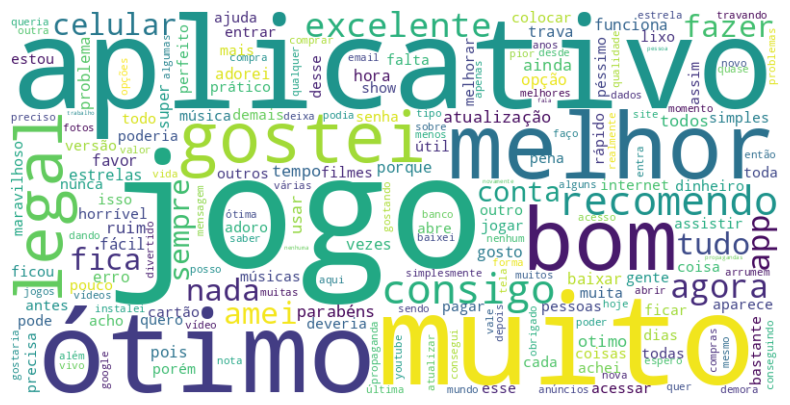

In [71]:
from wordcloud import WordCloud

def generate_word_cloud_from_dict(word_freq):

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_word_cloud_from_dict(count_words)


In [76]:
df2csv = pd.DataFrame({'review_text': corpus,
                   'polarity': dataset['polarity']})
df2csv

,review_text,polarity
0,curtindo,1.0
1,aplicativo absurdamente caro valor tornar prêm...,0.0
2,simples novo layout,1.0
3,estava problema acessar porém consegui resolve...,1.0
4,gostei jogo celular celular anos ainda parabén...,1.0
...,...,...
1039530,legal,1.0
1039531,assim ficar dentro situação bolsa família gostei,1.0
1039532,,0.0
1039533,excelente aplicativo treinar conhecimentos ing...,1.0


In [77]:
df2csv.to_csv('output.csv')